In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
import os
import shutil
import random
import time

path = "C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning"
print(path)

VERIFY_TEST_SET = False
PLOT_TRAIN = False
PLOT_TEST = True
PLOT_TEST_LOSS = False
MAX_LAYERS = 4

C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning


In [2]:
def load_data(path: str):
    """
    This function loads data from a pickle file located at the provided path.

    Parameters:
        path (str): The path to the pickle file.

    Returns:
        par_comb (np.ndarray): The parameter combinations.
        S11_par (np.ndarray): The best parametric data.
        frequency (np.ndarray): The frequency data.
        degrees (np.ndarray): The degrees data.
        combined_gain (np.ndarray): The combined gain list.
        std_dev (np.ndarray): The standard deviation of Phi.
        efficiency (np.ndarray): The efficiency data.
    """

    with open(path,'rb') as file:
        data_dict = pickle.load(file)
    print(f"Dictionary keys: {data_dict.keys()}")

    par_comb = np.asarray(data_dict['Parameter combination'])
    S11_vals = np.asarray(data_dict['S1,1'])
    frequency = np.asarray(data_dict['Frequency'])
    S11_parametrized = np.asarray(data_dict['Parametric S1,1'])
    degrees = np.asarray(data_dict['degrees'])
    combined_gain = np.asarray(data_dict['combined gain list'])
    std_dev = np.asarray(data_dict['Standard deviation Phi'])
    efficiency = np.asarray(data_dict['efficiency'])
    #efficiency = np.asarray(list(data_dict['efficiency'].values()))
    return par_comb, S11_vals, S11_parametrized, frequency, degrees, combined_gain, std_dev, efficiency

def normalize_data(data, inverse: bool):
    if inverse:
        data_norm = data*np.std(data) + np.mean(data)
    else:   
        mean = np.mean(data)
        std = np.std(data)
        data_norm = (data-mean)/std
    return data_norm


In [3]:
path = 'C:/Users/nlyho/Desktop/MachineLearning/'
par_comb, S11_vals, S11_parameterized, frequency, degrees, combined_gain, std_dev, efficiency = load_data(f"C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning/data/simple_wire2_final_with_parametric.pkl")

# Normalize data
par_comb_norm = normalize_data(par_comb, False)
S11_vals_norm = normalize_data(S11_vals, False)
S11_parameterized_norm = normalize_data(S11_parameterized, False)
frequency_norm = normalize_data(frequency, False)
degrees_norm = normalize_data(degrees, False)
combined_gain_norm = normalize_data(combined_gain, False)
std_dev_norm = normalize_data(std_dev, False)
efficiency_norm = normalize_data(efficiency, False)


input_vector = par_comb_norm

output_vector = np.asarray([np.concatenate((S11_vals_norm[i], [std_dev[i]], [efficiency_norm[i]]))for i in range(S11_vals.shape[0])])


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_vector, output_vector, test_size=0.3, shuffle=True, random_state=42)


std_dev = y_test[:,-2]
efficiency = y_test[:,-1]

if VERIFY_TEST_SET:
    # Find test curves where the S11 goes below -10 dB and the frequency is below 2 GHz
    test_indices = []
    for idx, i in enumerate(y_test):
        if np.min(i) < -10 and frequency[np.argmin(i)] < 2000:
            test_indices.append(idx)
    print(f"Number of test curves that satisfy the condition: {len(test_indices)} within the test set")

    # Select 10 random curves from the good test curves
    random_indices = random.sample(test_indices, 10)

    # plot random test data curves to verify that a good solution is within the test set
    plt.figure(figsize=(50, 50))
    for idx, i in enumerate(random_indices):
        plt.subplot(5, 2, idx+1)
        plt.plot(frequency, y_test[i][0:1001], label='test')
        plt.legend()
        plt.grid(True)
        plt.ylim([-40,2])
    plt.show()

Dictionary keys: dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'degrees', 'combined gain list', 'Standard deviation Phi', 'efficiency', 'Parametric S1,1'])


In [4]:
# Make a 4 layer neural network using relu activation functions
model = keras.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='linear'))

# Create lists to store the results
loss_train = []
mean_error_train = []
mean_error_pred = np.zeros(50)

model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.MeanAbsoluteError(),
            metrics=[keras.metrics.MeanSquaredError()]
        )
model.summary()


# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=100,
                    shuffle=True,
                    verbose=1)

# Define the loss and accuracy for the training and test data
loss_train.extend(model.history.history['loss'])
mean_error_train.extend(model.history.history['mean_squared_error'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 1003)              257771    
                                                                 
Total params: 521963 (1.99 MB)
Trainable params: 521963 

In [ ]:
if PLOT_TRAIN:
    plt.figure()
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(121)
    plt.plot(np.array(loss_train).T)
    plt.ylabel('Absolute error')
    plt.xlabel('epoch')
    plt.legend(['Absolute error'])
    plt.ylim([0, 1])
    plt.subplot(122)
    plt.plot(np.array(mean_error_train).T)
    plt.ylabel('Mean-squared error')
    plt.xlabel('epoch')
    plt.legend(['Mean-squared error'])
    plt.ylim([0, 1])
    
    # For saving the training loss figure
    train_loss_path = os.path.join(path, 'data', 'DNN_results', 'relu', 'train_loss', f'MADStrain_loss_4_layer.png').replace("\\", "/")
    plt.show()
    # plt.savefig(train_loss_path)
    # plt.close()


In [ ]:
# Run the model on the test data and get the loss and mean-squared error
y_pred_norm = model.predict(X_test)
_ , mean_error_pred = model.evaluate(X_test, y_test)


# Reverse the normalization
y_pred_s11 = normalize_data(y_pred_norm[:,:1001], inverse=True)
std_dev_pred = normalize_data(y_pred_norm[:,-2], inverse=True)
efficiency_pred = normalize_data(y_pred_norm[:,-1], inverse=True)

# Find test curves where the S11 goes below -10 dB and the frequency is below 2 GHz
test_indices = []
for idx, i in enumerate(y_test):
    if np.min(i) < -10 and frequency[np.argmin(i)] < 2000:
        test_indices.append(idx)
print(f"Number of test curves that satisfy the condition: {len(test_indices)} within the test set")

# Select 10 random curves from the good test curves
random_indices = random.sample(test_indices, len(test_indices))


error_std_dev = np.abs(std_dev - std_dev_pred)
MSE_std_dev = np.mean(error_std_dev**2)

error_efficiency = np.abs(efficiency - efficiency_pred)
MSE_efficiency = np.mean(error_efficiency**2)

error_dictionary = {'error_std_dev': error_std_dev.tolist(), 'MSE_std_dev': MSE_std_dev.tolist(), 'error_efficiency': error_efficiency.tolist(), 'MSE_efficiency': MSE_efficiency.tolist()}
print(f'MSE_std_dev: {error_dictionary["MSE_std_dev"]}, MSE_efficiency: {error_dictionary["MSE_efficiency"]}')



24/24 [==============================] - 0s 2ms/step - loss: 0.0478 - mean_squared_error: 0.0313
Number of test curves that satisfy the condition: 3 within the test set
MSE_std_dev: 40.6419636733663, MSE_efficiency: 0.008326792289400252


ValueError: x and y must have same first dimension, but have shapes (1001,) and (1003,)

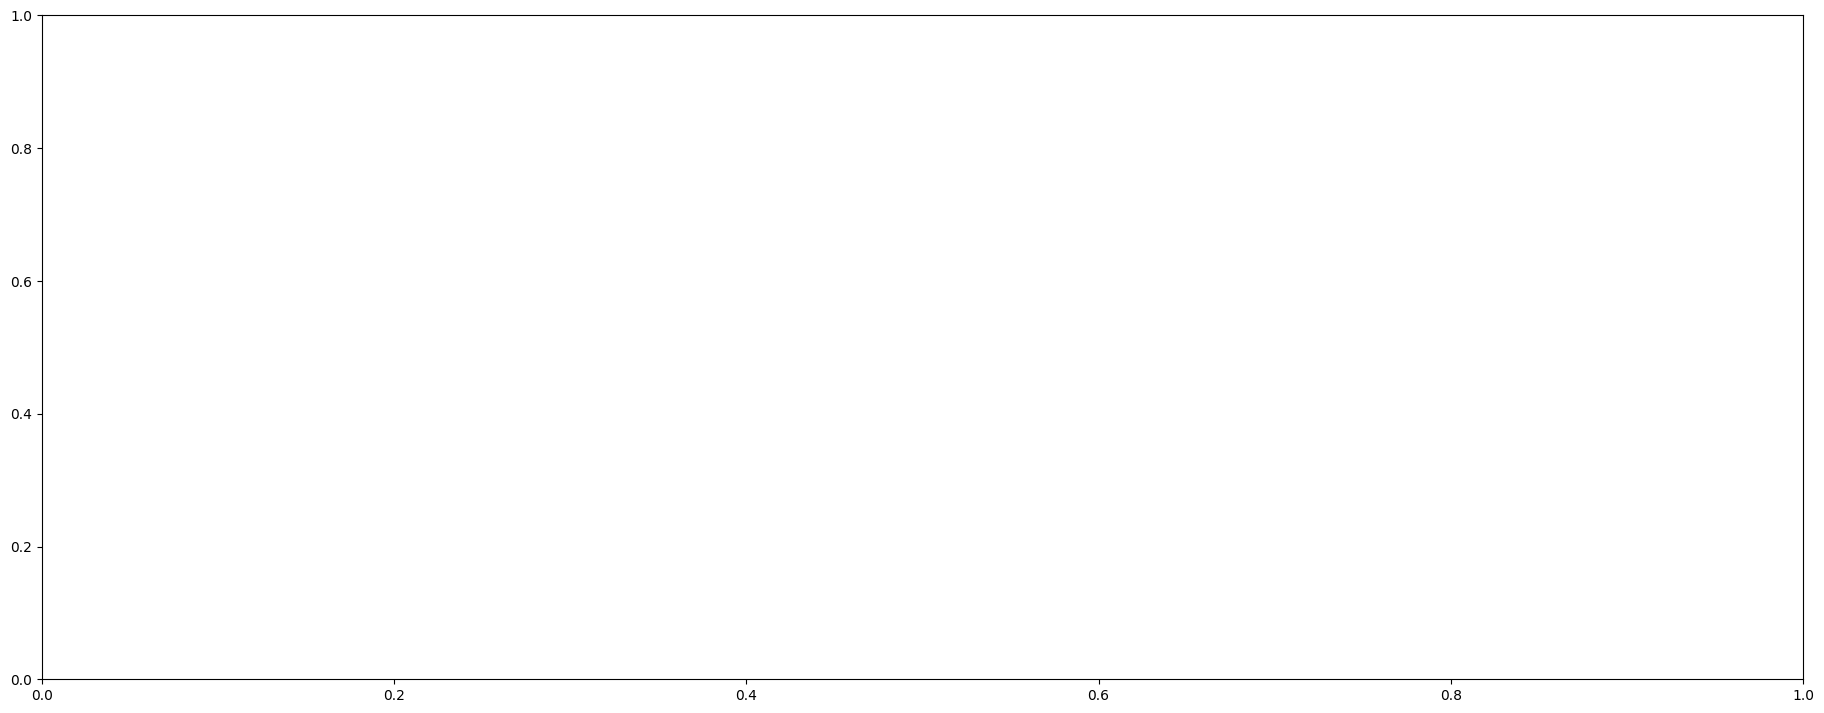

In [ ]:
# Plot the test data and the predicted data
if PLOT_TEST: 
    plt.figure(figsize=(50, 50))
    for idx, i in enumerate(random_indices):
        plt.subplot(5, 2, idx+1)
        plt.plot(frequency, y_pred_s11[i], label='pred')
        plt.plot(frequency, y_test[i][:1001], label='test')
        plt.legend()
        plt.grid(True)
        plt.ylim([-40,2])
    plt.show()
    # For saving the testing prediction figure
    # test_pred_path = os.path.join(path, 'data', 'DNN_results', 'relu', 'test_pred_good', f'MADStest_pred_layer{layer+1}', f'test_pred_{(j+1)*10}.png').replace("\\", "/")
    # plt.savefig(test_pred_path)
    # plt.close()

In [ ]:
 # Plot the testing loss
if PLOT_TEST_LOSS:
    plt.plot(np.arange(1,1000,1), mean_error_pred)
    plt.ylabel('Mean-squared error')
    plt.xlabel('epoch')
    plt.ylim([0,0.6])
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# # Plot the training and validation loss
# plt.figure(figsize=(10, 10))
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the training and validation mae
# plt.figure(figsize=(10, 10))
# plt.plot(history.history['mae'], label='Training mae')
# plt.plot(history.history['val_mae'], label='Validation mae')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Evaluate the model on the test set
# test_loss, test_mae = model.evaluate(X_test, y_test)
# print(f"Test loss: {test_loss}")
# print(f"Test mae: {test_mae}")

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Plot the predicted S11 values
# plt.figure(figsize=(50, 50))
# for idx, i in enumerate(random_indices):
#     plt.subplot(5, 2, idx+1)
#     plt.plot(frequency, y_test[i][0:1001], label='test')
#     plt.plot(frequency, y_pred[i][0:1001], label='predicted')
#     plt.legend()
#     plt.grid(True)
#     plt.ylim([-40,2])
# plt.show()
